# Clean the Steam dataset

In [1]:
import os
import gzip
import json
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import dateutil.parser

## 1. Helper functions

In [2]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
    #read gzipped content
    f = gzip.open(filename_gzipped_python_json,'r')
    #parse json
    parse_data = []
    for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
        line = line.decode('utf-8')
        line = line.replace('true','True') #difference json/python
        line = line.replace('false','False')
        parsed_result = eval(line) #load python nested datastructure
        parse_data.append(parsed_result)
        if read_max !=-1 and len(parse_data) > read_max:
            print(f'Break reading after {read_max} records')
            break
    #create dataframe
    df= pd.DataFrame.from_dict(parse_data)
    return df

# show distributions of values
def show_distribution(xlabel, x, use_log=False):
    x = x.to_numpy()
    if use_log:
        x = np.log2(x.clip(min=1))
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    for ax in axes:
        sns.kdeplot(x, shade=False, color='crimson', ax=ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Showing mean and sdev')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Showing median and quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
        ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
        ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
        ax.set_xlabel(f'log2({xlabel})' if use_log else str(xlabel))
    plt.show()

## 2. Load data
Create a raw dataframe so that we can rerun certain cells without reading the file again.

In [3]:
path = os.getcwd()  # working directory
games_raw = parse_json(os.path.join(path, 'steam_games.json.gz'))
users_raw = parse_json(os.path.join(path, 'australian_users_items.json.gz'))

32135it [00:01, 16305.87it/s]
88310it [00:57, 1544.92it/s]


## 3. Clean games

In [97]:
games = games_raw.copy()
# a game must have a name, also drop duplicate games
games = games.dropna(subset=['app_name']).drop_duplicates(subset=['app_name'])

### 3.1 Categories
Here, we merge `genres`, `tags`, `specs` and `early_access`. This allows us to easily create a feature vector from the meta-data.

In [98]:
# fill categorial data NA with empty list
for c in ['genres', 'tags', 'specs']:
    games[c] = games[c].apply(lambda x: x if isinstance(x, list) else [])

# early access is also a category in the column 'tags'
early_access = games['early_access'].apply(lambda x: ['Early Access'] if x else [])
      
#  merge categorial data from genres, tags and specs
games['categories'] = games['genres'] + games['tags'] + games['specs'] + early_access
# remove duplicates
games['categories'] = games['categories'].apply(lambda x: list(set(x)))

categories_dict = {}
for g in games['categories']:
    for s in g:
        if s in categories_dict:
            categories_dict[s] += 1
        else:
            categories_dict[s] = 1

categories = pd.DataFrame(data={'category': categories_dict.keys(), 'count': categories_dict.values()})
categories = categories[categories['count'] > 1] \
            .sort_values(by=['count'], ascending=False) \
            .reset_index(drop=True)

categories.head()

,category,count
0,Single-player,27540
1,Indie,17620
2,Steam Achievements,16351
3,Action,12999
4,Downloadable Content,12683


In [99]:
# reconstruct dict with popular gategories having a low index
categories_dict = dict(zip(categories['category'], range(len(categories['category']))))

def parse_categories(x):
    ids = [categories_dict[c] for c in x if c in categories_dict]
    return np.array(sorted(ids))

games['categories'] = games['categories'].apply(parse_categories)

games[['app_name', 'categories']].head()

,app_name,categories
0,Lost Summoner Kitty,"[0, 1, 3, 8, 10, 11]"
1,Ironbound,"[0, 1, 2, 5, 9, 11, 15, 19, 20, 22, 28, 41, 44..."
2,Real Pool 3D - Poolians,"[0, 1, 8, 9, 10, 20, 21, 22, 23, 34, 63]"
3,弹炸人2222,"[0, 3, 7, 8]"
4,Log Challenge,"[0, 1, 3, 8, 12, 26, 31, 34, 38, 51]"


<AxesSubplot:xlabel='categories', ylabel='log2(count)'>

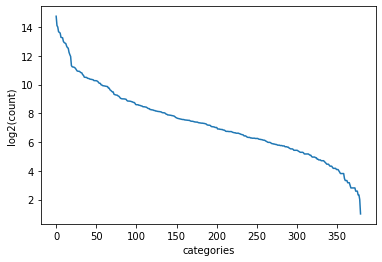

In [100]:
# usages of catagories
cat_plot = categories.reset_index()
cat_plot['log2(count)'] = np.log2(cat_plot['count'])
sns.lineplot(data=cat_plot.rename(columns={'index':'categories'}), x='categories', y='log2(count)')

### 3.2 Price
There are some games in the dataset that are almost 1000 euro.
Using the log for price will create a nice price distribution.

In [101]:
def parse_price(x):
    try:
        return float(x)
    except:
        return 0

games['price_clean'] = games['price'].fillna(0)
games['price_clean'] = games['price_clean'].apply(parse_price)

# there are some games close to 1000 euro, so take the log2 
games['price_clean'] = np.log2(1 + games['price_clean'])

# normalize to [0,1] range
games['price_clean'] /= games['price_clean'].max()

games[['app_name', 'price', 'price_clean']].head()

,app_name,price,price_clean
0,Lost Summoner Kitty,4.99,0.259293
1,Ironbound,Free To Play,0.000000
2,Real Pool 3D - Poolians,Free to Play,0.000000
3,弹炸人2222,0.99,0.099676
4,Log Challenge,2.99,0.200441


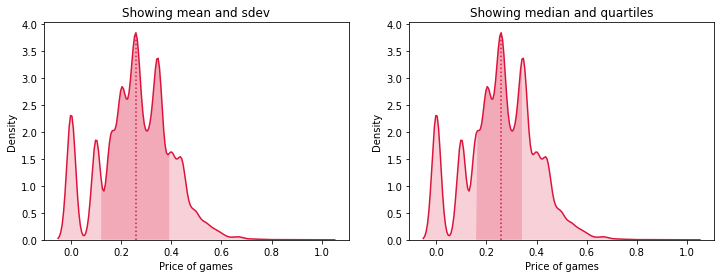

In [102]:
show_distribution('Price of games', games['price_clean'])

### 3.3 Sentiment
The sentiment indications used by steam are actually ratings in combination with the amount of reviews.

https://i.redd.it/p5etwl9mo5o51.png

We can convert these ratings to get good estimates on 2 new features: `rating` and `n_reviews`.

In [103]:
# display sentiment in numbers using 
# https://i.redd.it/p5etwl9mo5o51.png
sentiment_map = {
    'Overwhelmingly Negative' : (0.1, 1.0),
    'Very Negative' : (0.1, 0.6),
    'Negative' : (0.1, 0.1),
    'Mostly Negative' : (0.3, 0.5),
    '1 user reviews' : (0.5, 0.002),
    '2 user reviews' : (0.5, 0.004),
    '3 user reviews' : (0.5, 0.006),
    '4 user reviews' : (0.5, 0.008),
    '5 user reviews' : (0.5, 0.010),
    '6 user reviews' : (0.5, 0.012),
    '7 user reviews' : (0.5, 0.014),
    '8 user reviews' : (0.5, 0.016),
    '9 user reviews' : (0.5, 0.018),
    'Mixed' : (0.55, 0.5),
    'Mostly Positive' : (0.75, 0.5), 
    'Positive' : (0.9, 0.1), 
    'Very Positive' : (0.9, 0.6), 
    'Overwhelmingly Positive' : (1.0, 1.0),
}
# fill nan with '1 user reviews'
sentiment = games['sentiment'].apply(lambda x: x if isinstance(x, str) else '1 user reviews')
# create new columns based on the sentiment
games['sentiment_rating'] = sentiment.apply(lambda x: sentiment_map[x][0])
games['sentiment_n_reviews'] = sentiment.apply(lambda x: sentiment_map[x][1])

games[['app_name', 'sentiment', 'sentiment_rating', 'sentiment_n_reviews']].head()

,app_name,sentiment,sentiment_rating,sentiment_n_reviews
0,Lost Summoner Kitty,NaN,0.50,0.002
1,Ironbound,Mostly Positive,0.75,0.500
2,Real Pool 3D - Poolians,Mostly Positive,0.75,0.500
3,弹炸人2222,NaN,0.50,0.002
4,Log Challenge,NaN,0.50,0.002


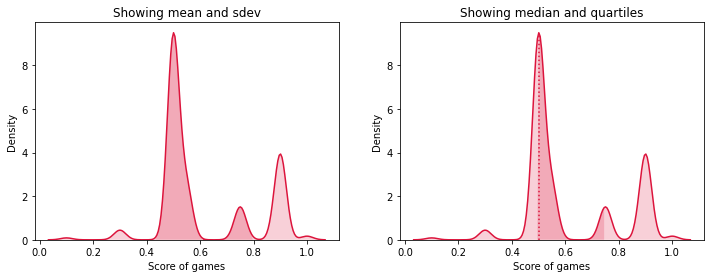

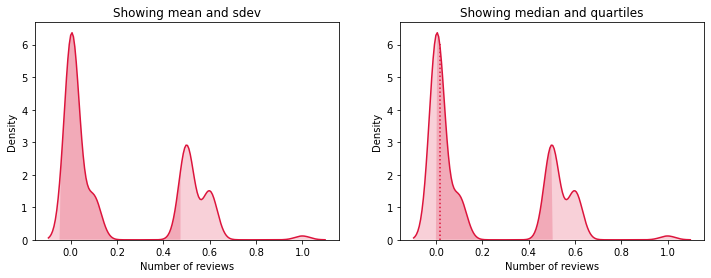

In [104]:
show_distribution('Score of games', games['sentiment_rating'])
show_distribution('Number of reviews', games['sentiment_n_reviews'])

### 3.4 Release dates
Most of the entries can be fixed to get a best guess on the release date.
Release dates containing TBD, TBA, Soon or `None` can for example be placed to a recent date.

In [105]:
# string to lower
release_dates = games['release_date'].str.lower()

# remove/replace text in the strings
for r in ['\(', '\)', '\[', '\]', 'coming', 'ish', '年初頭発売予定', 'early access', 'tentative', 
          'январь', 'hitting', 'in ', '年1月', 'now get free pre alpha', 'when it\'s done']:
    release_dates = release_dates.str.replace(r, '', regex=True)
    
for r in ['soon', 'tba', 'tbd']:
    release_dates[release_dates.str.contains(r, regex=True, na=False)] = None

# replace
for r, t in [('spring', 'April'), ('summer', 'July'), ('fall', 'October'), ('winter', 'December'),
             ('end', 'November'), ('q1', 'February'), ('1st quarter', 'February'), ('first quarter of', 'February'),
             ('q2', 'May'), ('q3', 'August'), ('q4', 'November'), ('early', 'March'), ('h1', 'April'), ('h2', 'October'),
             ('first quarter of', 'February'), ('late', 'October'), ('March April', 'April'), ('October 2016 \- ', '') ]:
    release_dates = release_dates.str.replace(r, t, regex=True) 

# returns number of days from t0
t0 = dateutil.parser.parse('1-1-1900')
def parse_date(d):
    if isinstance(d, str):
        try:
            return (dateutil.parser.parse(d) - t0).total_seconds() / (60*60*24)
        except Exception as e:
            pass
    return -1

# convert date to days (starting from 1-1-1990)
release_dates = release_dates.apply(parse_date)
# games without a date (mostly 'TBA' and 'soon') will get a fairly recent date
release_dates[release_dates < 0] = 43180
# normalize to [0,1] range
release_dates -= release_dates.min()
release_dates /= release_dates.max()

games['release_date_clean'] = release_dates

games[['app_name', 'release_date', 'release_date_clean']].head()

,app_name,release_date,release_date_clean
0,Lost Summoner Kitty,2018-01-04,0.922488
1,Ironbound,2018-01-04,0.922488
2,Real Pool 3D - Poolians,2017-07-24,0.913763
3,弹炸人2222,2017-12-07,0.920998
4,Log Challenge,NaN,0.926637


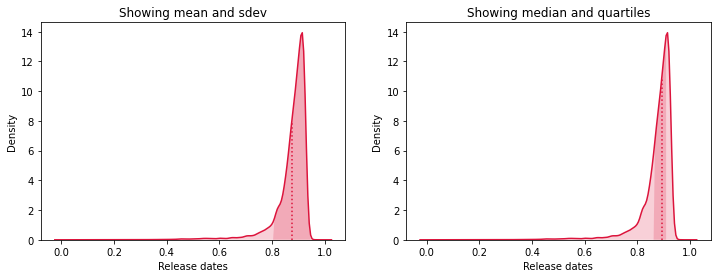

In [106]:
show_distribution('Release dates', games['release_date_clean'])

### 3.5 Data types
Change values to float32 or int32 if needed.

In [107]:
games = games.astype({'app_name': 'str', 
                      'price_clean': 'float32',
                      'release_date_clean': 'float32', 
                      'sentiment_rating': 'float32',
                      'sentiment_n_reviews': 'float32'})

## 4. Users

In [108]:
# copy raw dataset
# show id and count as integers
users = users_raw[['steam_id', 'items_count','items']] \
          .astype({'steam_id': 'int64', 'items_count': 'int32'})

#remove empty users directly
users = users[users['items_count'] > 0]

### 4.1 Filter old snapshot
The dataset contains 2 snapshots of the playtimes of the users. We want to use the most recent one.

In [109]:
# calculate playtime of the user (forever + 2weeks)
# the highest value is the most recent one
users['sum_playtimes'] = users['items'].apply(lambda x: sum([int(d['playtime_forever']) + int(d['playtime_2weeks']) for d in x]))
users = users.sort_values(by=['sum_playtimes'], ascending=False)
users = users.drop_duplicates(subset=['steam_id'], keep='first')

In [110]:
users.head()

,steam_id,items_count,items,sum_playtimes
19301,76561197995207074,1969,"[{'item_id': '1900', 'item_name': 'Earth 2160'...",4883592
19061,76561198034699157,1576,"[{'item_id': '60', 'item_name': 'Ricochet', 'p...",3303799
15959,76561198007282725,571,"[{'item_id': '300', 'item_name': 'Day of Defea...",2924661
17183,76561197963293081,1621,"[{'item_id': '10', 'item_name': 'Counter-Strik...",2791999
37446,76561198043711805,835,"[{'item_id': '300', 'item_name': 'Day of Defea...",1742479


### 4.2 Apply constraints
Because we will create a train/test/eval split, a user must have at least 3 games.
There are also multiple users that own approximately 80% of the games in the dataset. These most popular users (> 2^10 games) could be removed. 
(However, ratings based on the playtime will be very low, since a user will not have enough time to play all the games in its library.)

Removing users might cause some games to be left without any users, or removing games can cause a user to have less than 3 games. This is why the wile loop is introduced.

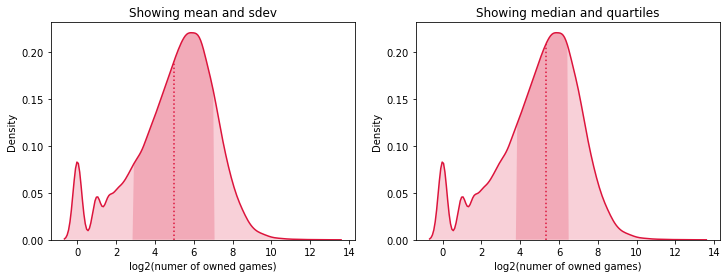

In [111]:
show_distribution('numer of owned games', users['items_count'], use_log=True)

In [112]:
def get_dict(_df):
    return dict(zip(_df.tolist(), range(len(_df))))

def count_games(df_games, df_users):
    _dict = get_dict(df_games['app_name'])
    _game_count = np.zeros(len(df_users), dtype=np.int32)
    for i, _user_items in enumerate(df_users['items']):
        for _json in _user_items:
            item_name = str(_json['item_name'])
            if item_name in _dict:
                _game_count[i] += 1
    return _game_count

def count_users(df_games, df_users):
    _dict = get_dict(df_games['app_name'])
    _user_count = np.zeros(len(df_games), dtype=np.int32)
    for _user_items in df_users['items']:
        for _json in _user_items:
            item_name = str(_json['item_name'])
            if item_name in _dict:
                _user_count[_dict[item_name]] += 1
    return _user_count


MIN_USER, MAX_USER = 3, 1024
MIN_GAME, MAX_GAME = 1, np.inf

# count the actual users/games
users['items_count'] = count_games(games, users)
games['users_count'] = count_users(games, users)

users = users[users['items_count'] <= MAX_USER]
games = games[games['users_count'] <= MAX_GAME]

# recount users/games, since we just deleted games and users
users['items_count'] = count_games(games, users)
games['users_count'] = count_users(games, users)

# keep deleting games and users until the condition is met
# in this case, we want a user to have at least 3 games and a game to have at least 1 user
while(users['items_count'].min() < MIN_USER or games['users_count'].min() < MIN_GAME):
    # filter
    users = users[users['items_count'] >= MIN_USER]
    games = games[games['users_count'] >= MIN_GAME]
    # recount users/games
    users['items_count'] = count_games(games, users)
    games['users_count'] = count_users(games, users)


# sort by popular users/items and reindex
users = users.sort_values(by=['items_count'], ascending=False).reset_index(drop=True)
games = games.sort_values(by=['users_count'], ascending=False).reset_index(drop=True)

# get the final dict
games_dict = get_dict(games['app_name'])

### 4.3 Get useful interactions
The interaction tuples are representing the following: 

`[game_id, playtime_forever, playtime_2weeks]`

In [125]:
def extract_user_interactions(user_items):
    _interactions = []
    for _json in user_items:
        item_name = str(_json['item_name'])
        if item_name in games_dict:
            item_id = games_dict[item_name]
            playtime_forever = int(_json['playtime_forever'])
            playtime_2weeks = int(_json['playtime_2weeks'])
            _interactions.append([item_id, playtime_forever, playtime_2weeks])
    return np.array(_interactions, dtype=np.int32)

users['interactions'] = users['items'].apply(extract_user_interactions)

users.head()

,steam_id,items_count,items,sum_playtimes,interactions
0,76561197981203305,1019,"[{'item_id': '300', 'item_name': 'Day of Defea...",496233,"[[127, 172, 0], [2275, 0, 0], [2133, 0, 0], [1..."
1,76561198029968002,1007,"[{'item_id': '2500', 'item_name': 'Shadowgroun...",779036,"[[558, 769, 0], [340, 595, 0], [2487, 1059, 0]..."
2,76561198067911521,1004,"[{'item_id': '300', 'item_name': 'Day of Defea...",164749,"[[127, 0, 0], [7, 126, 0], [52, 2, 0], [189, 0..."
3,76561197971666535,988,"[{'item_id': '10', 'item_name': 'Counter-Strik...",98234,"[[52, 1, 0], [61, 0, 0], [15, 156, 0], [7, 98,..."
4,76561198021307778,979,"[{'item_id': '240', 'item_name': 'Counter-Stri...",504824,"[[7, 1592, 0], [127, 165, 0], [22, 86, 0], [12..."


## 5. Store data to file

In [114]:
# split the dataframe in two
games_original = games[['publisher', 'genres', 'app_name', 'release_date', 'tags', 'discount_price', 'specs', 
                        'price', 'early_access', 'id', 'developer', 'sentiment', 'metascore', 'users_count']]
games_normalized = games[['app_name', 'categories', 'price_clean', 'sentiment_rating', 
                       'sentiment_n_reviews', 'release_date_clean', 'users_count']] \
                .rename(columns={'price_clean': 'price', 'release_date_clean': 'release_date'})

In [131]:
games_original.to_pickle(os.path.join(path, 'clean_dataset/games_original.pkl'))
games_normalized.to_pickle(os.path.join(path, 'clean_dataset/games_normalized.pkl'))
users[['interactions']].to_pickle(os.path.join(path, 'clean_dataset/interactions_all.pkl'))
categories.to_pickle(os.path.join(path, 'clean_dataset/categories.pkl'))

In [116]:
games_original.head()

,publisher,genres,app_name,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore,users_count
0,Valve,[Action],Counter-Strike: Global Offensive,2012-08-21,"[FPS, Multiplayer, Shooter, Action, Team-Based...",NaN,"[Multi-player, Steam Achievements, Full contro...",14.99,False,730,Valve,Very Positive,83,42620
1,Valve,"[Indie, Simulation]",Garry's Mod,2006-11-29,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",NaN,"[Single-player, Multi-player, Co-op, Cross-Pla...",9.99,False,4000,Facepunch Studios,Overwhelmingly Positive,NA,42157
2,Smartly Dressed Games,"[Action, Adventure, Casual, Free to Play, Indie]",Unturned,2017-07-07,"[Free to Play, Survival, Zombies, Multiplayer,...",NaN,"[Single-player, Online Multi-Player, Online Co...",Free to Play,False,304930,Smartly Dressed Games,Very Positive,NaN,37654
3,Valve,[Action],Left 4 Dead 2,2009-11-16,"[Zombies, Co-op, FPS, Multiplayer, Action, Onl...",NaN,"[Single-player, Multi-player, Co-op, Steam Ach...",19.99,False,550,Valve,Overwhelmingly Positive,89,35990
4,Re-Logic,"[Action, Adventure, Indie, RPG]",Terraria,2011-05-16,"[Sandbox, Adventure, Survival, 2D, Multiplayer...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,105600,Re-Logic,Overwhelmingly Positive,83,28551


In [117]:
games_normalized.head()

,app_name,categories,price,sentiment_rating,sentiment_n_reviews,release_date,users_count
0,Counter-Strike: Global Offensive,"[2, 3, 5, 9, 11, 12, 16, 21, 23, 30, 44, 49, 5...",0.401516,0.9,0.6,0.818109,42620
1,Garry's Mod,"[0, 1, 2, 3, 5, 6, 7, 9, 10, 16, 17, 19, 21, 3...",0.347201,1.0,1.0,0.706815,42157
2,Unturned,"[0, 1, 2, 3, 5, 6, 7, 8, 16, 17, 20, 21, 22, 2...",0.000000,0.9,0.6,0.912858,37654
3,Left 4 Dead 2,"[0, 2, 3, 5, 6, 7, 9, 12, 16, 17, 21, 23, 30, ...",0.440927,1.0,1.0,0.764431,35990
4,Terraria,"[0, 1, 2, 3, 5, 6, 7, 9, 12, 15, 16, 17, 21, 2...",0.347201,1.0,1.0,0.793478,28551


In [126]:
users[['interactions']].head()

,interactions
0,"[[127, 172, 0], [2275, 0, 0], [2133, 0, 0], [1..."
1,"[[558, 769, 0], [340, 595, 0], [2487, 1059, 0]..."
2,"[[127, 0, 0], [7, 126, 0], [52, 2, 0], [189, 0..."
3,"[[52, 1, 0], [61, 0, 0], [15, 156, 0], [7, 98,..."
4,"[[7, 1592, 0], [127, 165, 0], [22, 86, 0], [12..."


## 6. Create train/test split

Different options:
- **Time-based split**, i.e. split interactions before/after certain date. Keep all users with both training and test interactions for evaluations. Repeat for different train/test window, i.e. repeat for a number of key dates.
- **Session-based split**, i.e. split and keep first $x$ interactions for training and $|I_u| - x$  for testing, where $I_u = {i_1,\ldots,i_k}$ represents the user's history sorted on time
- **Random**, i.e. take $x$ random items for training and $|I_u| -x$ for testing
- **Leave-one-out**, i.e. take last (or random) item for testing

Additionaly, use techniques such as cross-validation and create multiple train/test splits and report both average and standard deviation.

In [119]:
def split_items(row):
    seed, user_items = row
    train, test = train_test_split(user_items, test_size=0.3, random_state=seed)
    # if test only contains 1 item, then we must split train instead of test
    if len(test) < 2:
        train, val = train_test_split(train, test_size=0.5, random_state=seed+1)
    else:
        test, val = train_test_split(test, test_size=0.5, random_state=seed+1)
    # transpost the array so that unpacking will be faster later on
    return [np.transpose(train), np.transpose(val), np.transpose(test)]

def create_train_test_val(df, seed):
    # create a view with seeds base on a seed
    result = pd.DataFrame({'seed': 2 * np.arange(len(df)) + seed})
    result['interactions'] = df['interactions']
    result = result.apply(split_items, axis=1, result_type='expand')
    result = result.rename(columns={0:'train', 1:'val', 2:'test'})
    return result

In [120]:
SEEDS = [42, 18, 27]

for i, seed in enumerate(tqdm(SEEDS)):
    create_train_test_val(users, seed).to_pickle(os.path.join(path, f'clean_dataset/interactions_split_{i}.pkl'))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.12s/it]


## 7. Unpack train/test split

In [127]:
def unpack_split(df, col):
    return pd.DataFrame({
        'item_id': df[col].apply(lambda x: x[0]),
        'playtime_forever': df[col].apply(lambda x: x[1]),
        'playtime_2weeks': df[col].apply(lambda x: x[2])
    })

dataset = pd.read_pickle(os.path.join(path, 'clean_dataset/interactions_split_0.pkl'))
dataset.head()

,train,val,test
0,"[[300, 924, 2877, 1588, 192, 35, 3596, 1531, 2...","[[2129, 1019, 1245, 1012, 1945, 3298, 1900, 76...","[[682, 561, 4927, 817, 217, 266, 53, 3062, 185..."
1,"[[5277, 1179, 1897, 141, 2825, 169, 1053, 1936...","[[1545, 2017, 5402, 2209, 1823, 2768, 992, 513...","[[213, 1900, 4025, 1456, 3141, 1438, 1757, 459..."
2,"[[1206, 55, 323, 440, 58, 3946, 698, 54, 3106,...","[[595, 330, 258, 1415, 2293, 1273, 1960, 527, ...","[[2460, 1989, 1301, 1857, 2507, 104, 56, 215, ..."
3,"[[1198, 2839, 342, 2052, 332, 1132, 2512, 475,...","[[101, 1005, 377, 866, 1153, 1069, 266, 2766, ...","[[681, 1804, 643, 729, 805, 915, 1029, 716, 19..."
4,"[[2083, 126, 106, 2249, 345, 4934, 669, 1957, ...","[[4943, 2124, 831, 2932, 897, 578, 3397, 4122,...","[[3, 1407, 1938, 540, 1006, 2205, 2291, 1746, ..."


In [128]:
unpack_split(dataset, 'train').head()

,item_id,playtime_forever,playtime_2weeks
0,"[300, 924, 2877, 1588, 192, 35, 3596, 1531, 24...","[0, 91, 236, 41, 283, 137, 91, 0, 685, 279, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[5277, 1179, 1897, 141, 2825, 169, 1053, 1936,...","[505, 294, 224, 255, 0, 1301, 1861, 679, 277, ...","[0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0..."
2,"[1206, 55, 323, 440, 58, 3946, 698, 54, 3106, ...","[0, 18, 67, 0, 1780, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1198, 2839, 342, 2052, 332, 1132, 2512, 475, ...","[37, 0, 0, 0, 55, 136, 95, 0, 92, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[2083, 126, 106, 2249, 345, 4934, 669, 1957, 0...","[0, 0, 236, 0, 0, 762, 205, 0, 2287, 37, 6, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [129]:
unpack_split(dataset, 'val').head()

,item_id,playtime_forever,playtime_2weeks
0,"[2129, 1019, 1245, 1012, 1945, 3298, 1900, 767...","[0, 15109, 107, 119, 91, 122, 0, 91, 0, 358, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1545, 2017, 5402, 2209, 1823, 2768, 992, 513,...","[222, 839, 0, 442, 0, 0, 336, 93, 658, 113, 28...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[595, 330, 258, 1415, 2293, 1273, 1960, 527, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[101, 1005, 377, 866, 1153, 1069, 266, 2766, 1...","[0, 0, 135, 0, 0, 0, 111, 0, 0, 0, 0, 83, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[4943, 2124, 831, 2932, 897, 578, 3397, 4122, ...","[80, 0, 3, 0, 2853, 14, 0, 175, 14, 17, 85, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [130]:
unpack_split(dataset, 'test').head()

,item_id,playtime_forever,playtime_2weeks
0,"[682, 561, 4927, 817, 217, 266, 53, 3062, 185,...","[0, 152, 0, 224, 8087, 175, 27005, 91, 0, 91, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[213, 1900, 4025, 1456, 3141, 1438, 1757, 459,...","[0, 883, 203, 401, 0, 242, 257, 207, 732, 188,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[2460, 1989, 1301, 1857, 2507, 104, 56, 215, 1...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[681, 1804, 643, 729, 805, 915, 1029, 716, 193...","[55, 0, 18, 101, 0, 0, 0, 0, 0, 0, 55, 55, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[3, 1407, 1938, 540, 1006, 2205, 2291, 1746, 3...","[719, 0, 198, 175, 926, 0, 235, 52, 124, 837, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
